In [1]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

dc = datacube.Datacube()
# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


# Sentinal 2 A&B Geomedian notebook

what does this notebook do? 

In [2]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], title='string', projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    title - string that the plot should be given as a title
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(title, fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [3]:

#set up peramiters for sentinal data loading

Ssensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want



Squery = {
        'lat': (-30.55, -30.60),
        'lon': (145.30, 145.35),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-06-01')
        }
# use s2b_ard_granule 	 for S2B
#data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

In [4]:
data_allsens = {}


for i in Ssensors:
    try:
        this_sensor = s2aws.load(product= i, group_by='solar_day', **Squery)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        #clear_pixelsa = this_sensor.pixel_quality != 2
        #clear_pixelsb = this_sensor.pixel_quality != 3
        #clear_pixels = clear_pixelsa * clear_pixelsb
        #clear_data = this_sensor.where(clear_pixels)
    
        data_allsens[i] = this_sensor

        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')
        
        #use masked vs UNmasked for geomedian depending on requierments 

s2a_ard_granule done
s2b_ard_granuledose not have any imagry for this time


In [5]:
#Temporal range, wavelengths/band and sensors of interest are defined for LANDSAT

Lsensors= ['ls8_nbart_albers'] #pick the landsat satelites you want

Lbands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

Lquery = {
        'lat': (-30.55, -30.65),
        'lon': (145.30, 145.40),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2015-07-01', '2017-12-30')
        }

# this quiery retreives our data request entered in above cell

data_land = dc.load(product='ls8_nbart_albers', group_by='solar_day',  **Lquery)



In [6]:
data_allsens['lst8_nbart_albers'] = data_land
data_allsens

{'lst8_nbart_albers': <xarray.Dataset>
 Dimensions:          (time: 114, x: 425, y: 487)
 Coordinates:
   * time             (time) datetime64[ns] 2015-07-03T00:07:03 ...
   * y                (y) float64 -3.391e+06 -3.391e+06 -3.391e+06 -3.391e+06 ...
   * x                (x) float64 1.259e+06 1.259e+06 1.259e+06 1.259e+06 ...
 Data variables:
     coastal_aerosol  (time, y, x) int16 347 357 387 366 400 397 440 404 411 ...
     blue             (time, y, x) int16 339 331 372 351 363 386 410 382 403 ...
     green            (time, y, x) int16 572 641 719 674 729 691 795 671 719 ...
     red              (time, y, x) int16 861 959 1287 1217 1285 1281 1635 ...
     nir              (time, y, x) int16 1761 1833 2194 1995 2024 1940 2199 ...
     swir1            (time, y, x) int16 2290 2696 3023 3193 2991 3046 3209 ...
     swir2            (time, y, x) int16 1679 2016 2452 2614 2460 2638 2910 ...
 Attributes:
     crs:      EPSG:3577, 's2a_ard_granule': <xarray.Dataset>
 Dimensions:    

In [7]:
data_allsens = xr.concat(data_allsens.values(),'time')
data_allsens = data_allsens.sortby('time')
data_allsens.attrs['crs'] = crs
data_allsens.attrs['affin|e'] = affine

KeyError: 'pixel_quality'

In [ ]:
data_allsens

In [7]:
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')
data_land_flt = data_land.astype(float,casting='safe')

In [22]:
#create slice of sentinal data which is only from the wet month

#wet_gm = data_sent_flt.sel(time=slice('2017-01-01', '2017-03-31'))
wet_gml = data_land_flt.sel(time=slice('2015-07-01', '2015-09-30'))

In [23]:
#create geomedian for data
#Sentinal_gm_wet=GeoMedian().compute(wet_gm)

In [24]:
#Sentinal_gm_wet

In [25]:
#create geomedian for data
land_gm_wet=GeoMedian().compute(wet_gml)

In [26]:
#dry_gm = data_sent_flt.sel(time=slice('2017-09-01', '2017-10-30'))
dry_gml = data_land_flt.sel(time=slice('2017-09-01', '2017-12-31'))

In [27]:
#create geomedian for data
#Sentinal_gm_dry=GeoMedian().compute(dry_gm)

In [28]:
#create geomedian for data
land_gm_dry=GeoMedian().compute(dry_gml)
    

<IPython.core.display.Javascript object>


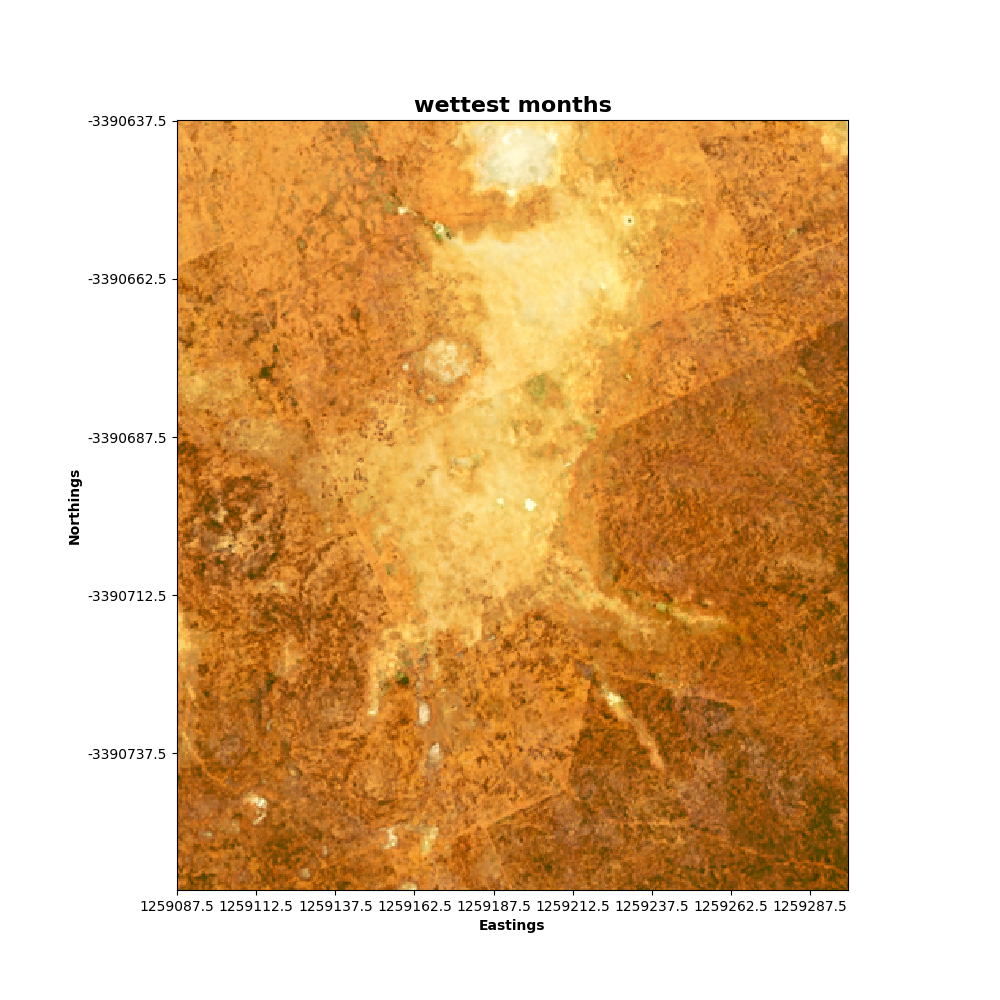

In [15]:
three_band_image_flat(land_gm_wet, bands=['red','green','blue'], title='wettest months')

<IPython.core.display.Javascript object>


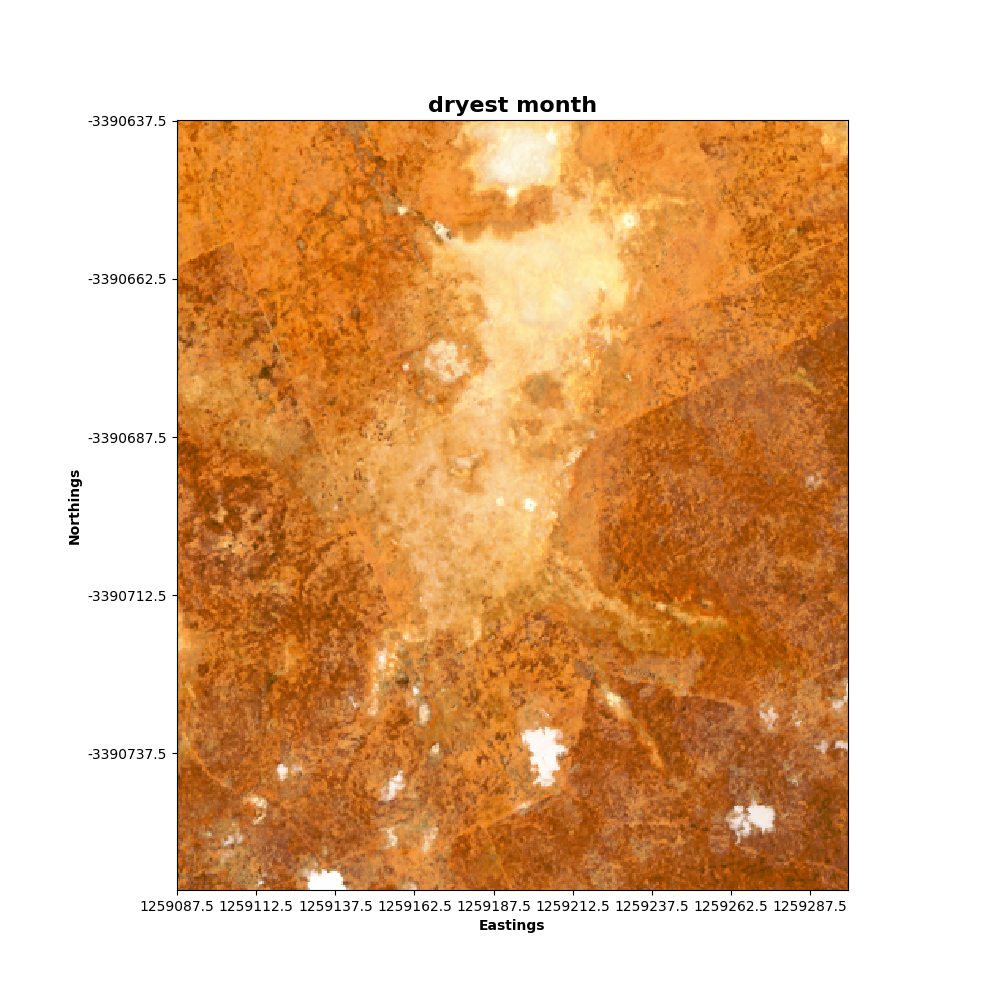

In [29]:
three_band_image_flat(land_gm_dry, bands=['red','green','blue'], title='dryest month')

In [17]:
wet_NDVI = (land_gm_wet['nir']-land_gm_wet['red'])/(land_gm_wet['nir']+land_gm_wet['red'])
dry_NDVI = (land_gm_dry['nir']-land_gm_dry['red'])/(land_gm_dry['nir']+land_gm_dry['red'])

In [30]:
NDVi_diff = wet_NDVI-dry_NDVI

In [31]:
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

<IPython.core.display.Javascript object>


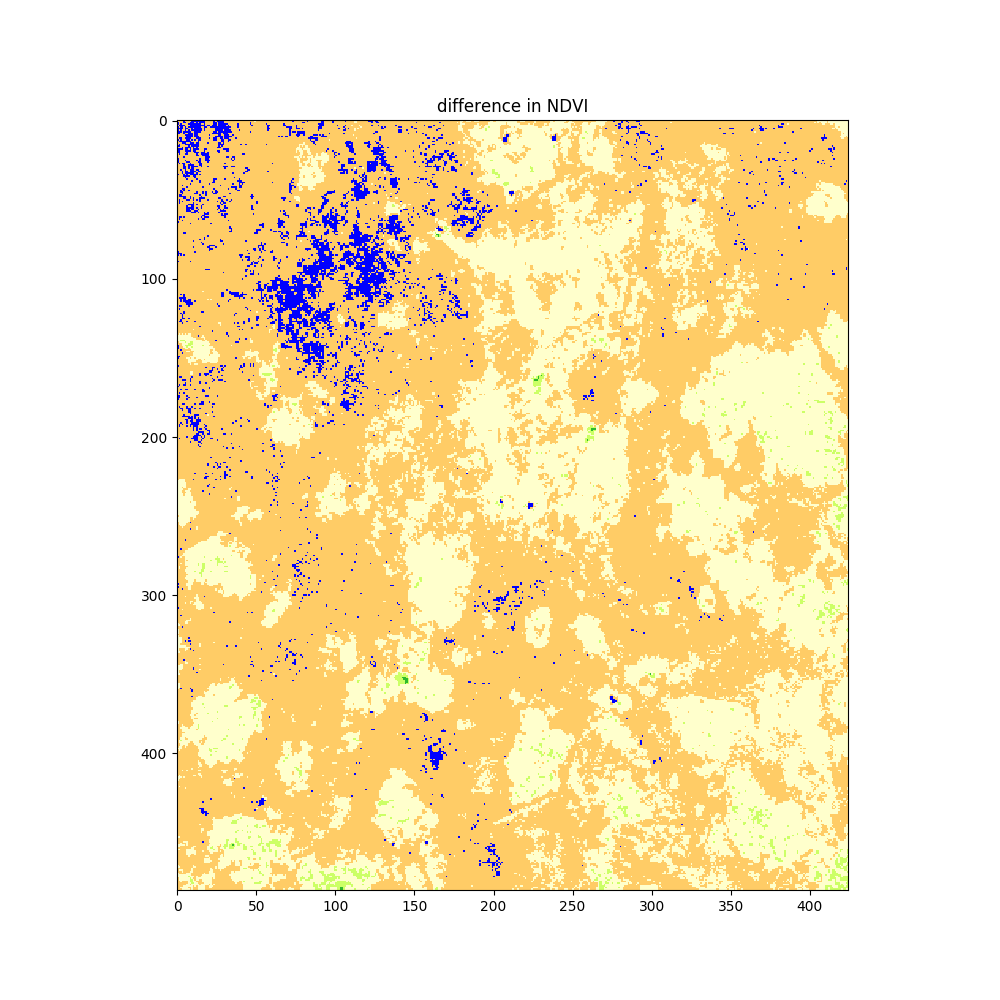

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('difference in NDVI')
ax.imshow(NDVi_diff, cmap = ndvi_cmap, norm = ndvi_norm)

<IPython.core.display.Javascript object>


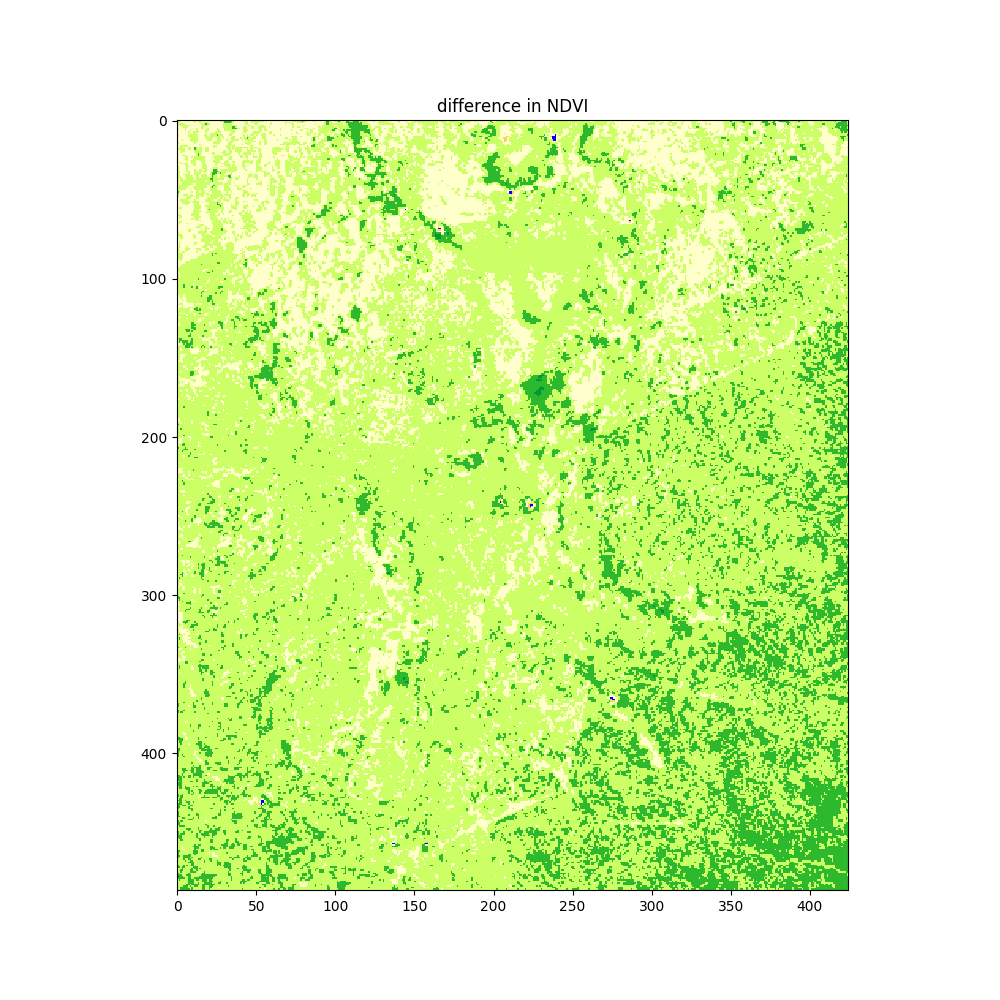

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('difference in NDVI')
ax.imshow(wet_NDVI , cmap = ndvi_cmap, norm = ndvi_norm)